In [1]:
%load_ext autoreload
%autoreload 2
import os

os.environ["LIBRARY_PATH"]="/usr/local/cuda-12.2/lib64/stubs:$LIBRARY_PATH"
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model_id = "meta-llama/Meta-Llama-3.1-70B-Instruct"

In [2]:


from src.llm.PredictionUtils import init_model_and_tokenizer, llm_gen


model, tokenizer = init_model_and_tokenizer(model_id,
                                            enable_lora=True,
                                            )

INFO 09-19 16:01:40 config.py:904] Defaulting to use mp for distributed inference
INFO 09-19 16:01:40 llm_engine.py:223] Initializing an LLM engine (v0.6.1.post2) with config: model='meta-llama/Meta-Llama-3.1-70B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3.1-70B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=2000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=8, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=meta-llam

Loading safetensors checkpoint shards:   0% Completed | 0/30 [00:00<?, ?it/s]


(VllmWorkerProcess pid=680452) INFO 09-19 16:01:59 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=680453) INFO 09-19 16:02:00 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=680457) INFO 09-19 16:02:00 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=680458) INFO 09-19 16:02:01 model_runner.py:1008] Loading model weights took 16.4634 GB
INFO 09-19 16:02:02 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=680454) INFO 09-19 16:02:02 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=680455) INFO 09-19 16:02:02 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=680456) INFO 09-19 16:02:03 model_runner.py:1008] Loading model weights took 16.4634 GB
INFO 09-19 16:02:09 distributed_gpu_executor.py:57] # GPU blocks: 81384, # CPU blocks: 6553
INFO 09-19 16:02:12 model_runner.py:1311] Capturing

In [3]:

from datasets import load_dataset

ds=load_dataset("kanhatakeyama/material-properties",split="Bradley")
ds=ds.shuffle(seed=1)
len(ds)

24889

In [4]:
train_ds = ds.select(range(24000))
test_ds = ds.select(range(24000, 24800))
train_ds[0]



{'CompName': '(2Z)-2-(1,3-Benzodioxol-5-ylmethylene)-6,7-dihydro-5H-[1,3]thiazolo[3,2-a]pyrimidin-3(2H)-one',
 'SMILES': 'O=C1C(SC2=NCCCN12)=Cc4ccc3OCOc3c4',
 'Property': 'Melting temperature',
 'Value': 151.35,
 'unit': '[oC]',
 'Source': 'BradleyMeltingPointDataset'}

In [5]:
import random
prompt_list=[]
problems=[]
n_records=200
target_ds=test_ds
n_records=min(n_records,len(target_ds))
for i in range(n_records):
    record=random.choice(target_ds)
    q=f"Predict "+record["Property"]+" "+record["unit"]+" for "+record["CompName"]+" (Compound X) with SMILES "+str(record["SMILES"])+". The prediction consists of #Reason and #Prediction. The #Reason is the quantitative explanation of the prediction. The #Prediction is the predicted value and the unit of the prediction."
    messages=[
        {"role": "user", "content": q},
    ]
    prompt=tokenizer.apply_chat_template(messages,tokenize=False)
    prompt_list.append(prompt+ "assistant\n\n#Reason\n")
    problems.append(record)


In [6]:
import glob
from tqdm import tqdm
from src.prop.utils import parse_Q_R_A_prediction
lora_model_list=glob.glob("output0919_threshold_0.1_lora_kqvo_proj/checkpoint-*")
lora_model_list= sorted(lora_model_list, key=lambda x: int(x.split('-')[-1]))

prediction_dict={}

cnt=0
for lora_model in tqdm(lora_model_list[:]):
    cnt+=1
    predicted_texts=llm_gen(model,prompt_list,
                            enable_lora=True,
                            lora_path=lora_model,
                            lora_id=cnt)
    good_records=parse_Q_R_A_prediction(predicted_texts,problems)
    prediction_dict[lora_model]=good_records

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:01<03:03, 61.21s/it]

could not convert string to float: '50-70'
could not convert string to float: '180-200'
could not convert string to float: '120-140'
could not convert string to float: '50-60'
could not convert string to float: '70-80'
could not convert string to float: '120-140'
could not convert string to float: '180-200'
could not convert string to float: '120-150'
could not convert string to float: 'K'
could not convert string to float: '185-195'
could not convert string to float: '210-230'
could not convert string to float: '80-120'
could not convert string to float: '43-48'
could not convert string to float: '180-200'
could not convert string to float: '80-100'
could not convert string to float: '150-160'
could not convert string to float: '120-150'
could not convert string to float: '125-135'
could not convert string to float: '180-200'
could not convert string to float: '120-140'
could not convert string to float: '50-60'
could not convert string to float: '185-200'
could not convert string to 

 50%|█████     | 2/4 [02:03<02:03, 61.74s/it]

could not convert string to float: '180-200'
could not convert string to float: '180-220'
could not convert string to float: '55[oC]'
could not convert string to float: '180-200'
could not convert string to float: '50-60'
could not convert string to float: '40-50'


100%|██████████| 4/4 [04:01<00:00, 60.39s/it]


In [7]:

predicted_texts=llm_gen(model,prompt_list,
                        enable_lora=False,
                        )

Processed prompts: 100%|██████████| 200/200 [00:31<00:00,  6.44it/s, est. speed input: 769.91 toks/s, output: 1713.09 toks/s]


TypeError: parse_Q_R_A_prediction() missing 1 required positional argument: 'problems'

In [8]:

good_records=parse_Q_R_A_prediction(predicted_texts,problems)
prediction_dict["original"]=good_records

could not convert string to float: '180-200'
could not convert string to float: '55-62'
could not convert string to float: '110-130'
could not convert string to float: '170-220'
could not convert string to float: '225-250'
could not convert string to float: '195-200'
could not convert string to float: '45-55'
could not convert string to float: '220-230'
could not convert string to float: '150-160'
could not convert string to float: '240-260'
could not convert string to float: '120-140'
could not convert string to float: '180-200'
could not convert string to float: '160-180'
could not convert string to float: '140-160'
could not convert string to float: '40-60'
could not convert string to float: '220-250'
could not convert string to float: '140-160'
could not convert string to float: '55-65'
could not convert string to float: '120-140'
could not convert string to float: '20-25'
could not convert string to float: '210-220'
could not convert string to float: '220-250'
could not convert st

In [9]:
#import json 
#with open("data/predict/0919prediction_dict_kqvo_proj.json","w") as f:
#    json.dump(prediction_dict,f,indent=2)

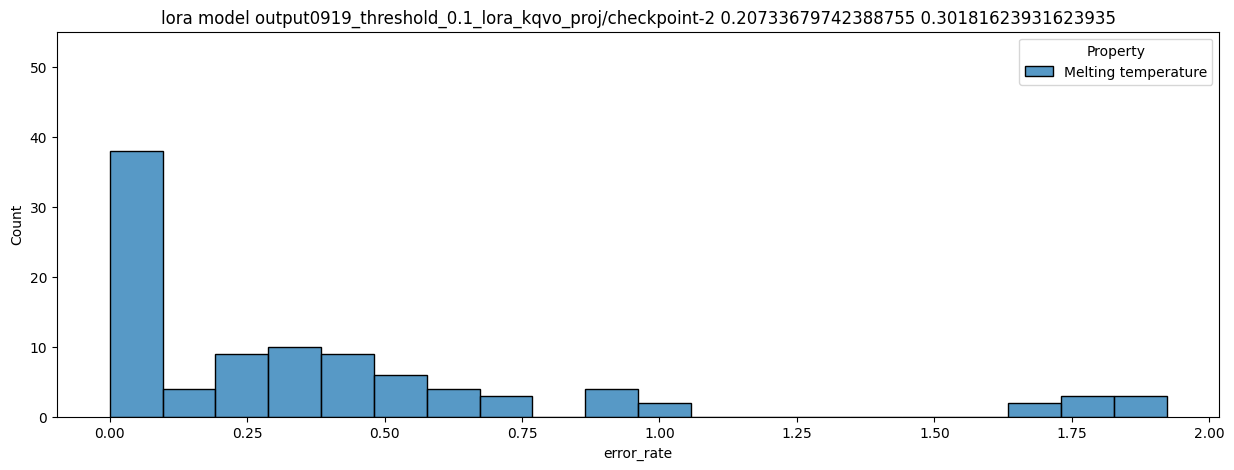

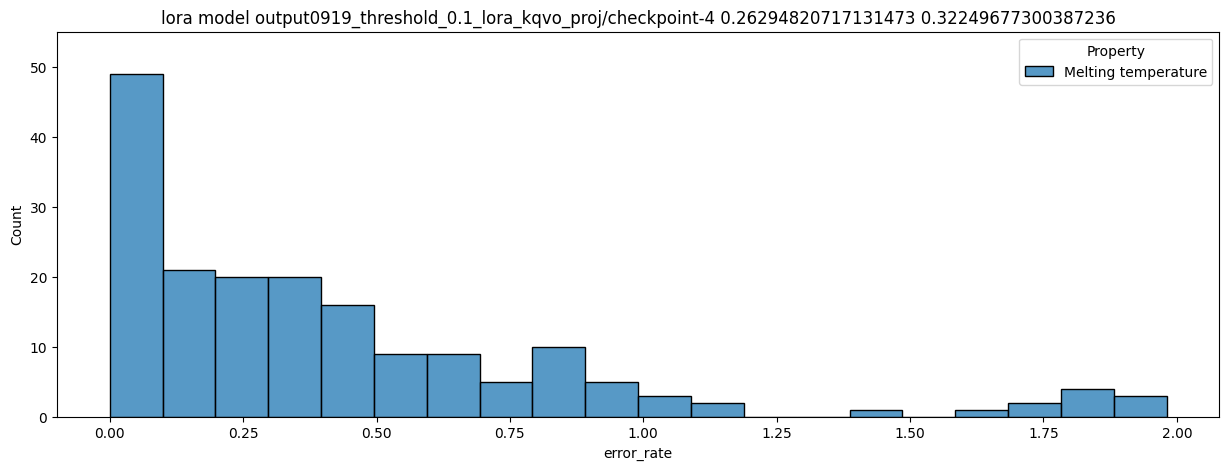

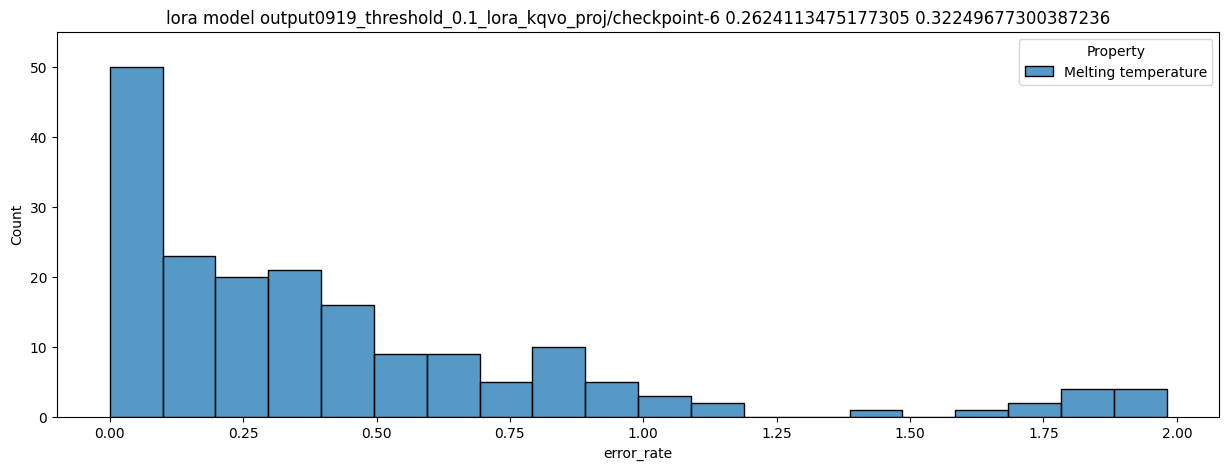

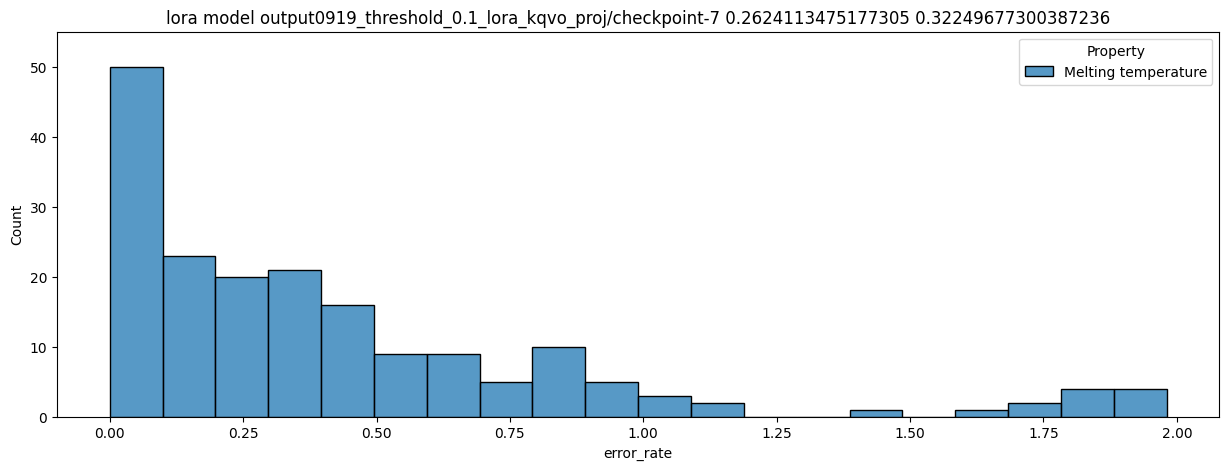

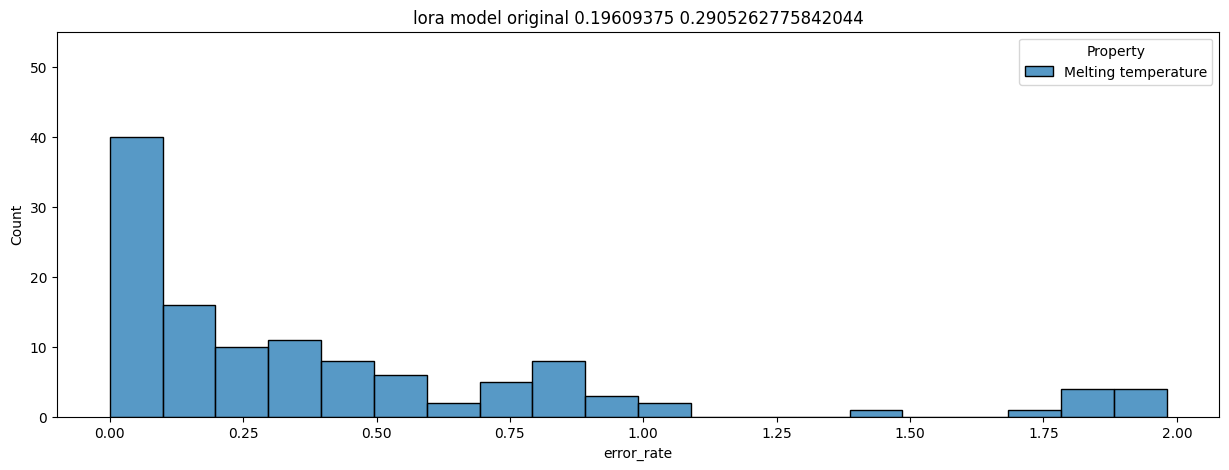

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for lora_name,good_records in prediction_dict.items():

    df=pd.DataFrame(good_records)

    plt.figure(figsize=(15, 5))
    sns.histplot(df[df["error_rate"]<2], x="error_rate", hue="Property", multiple="stack", 
                bins=20)


    s_df=df[df["error_rate"]<1]
    median1=s_df["error_rate"].median()
    median2=df["error_rate"].median()
    plt.title(f"lora model {lora_name} {median1} {median2}")
    plt.ylim(0, 55)